# Info

https://www.kaggle.com/datasets/balraj98/edges2shoes-dataset

In [63]:
# import shutil
# import os

# output_dir = '/kaggle/working'

# for filename in os.listdir(output_dir):
#     file_path = os.path.join(output_dir, filename)
#     try:
#         if os.path.isfile(file_path) or os.path.islink(file_path):
#             os.unlink(file_path)
#         elif os.path.isdir(file_path):
#             shutil.rmtree(file_path)
#     except Exception as e:
#         print(f'Failed to delete {file_path}. Reason: {e}')

# print('All files in /kaggle/working have been deleted.')


# Libraries Import

In [64]:
import glob
import cv2
import tqdm

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
import kagglehub

In [67]:
import os
from collections import Counter
import random
import re
import json
import pickle

In [116]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import plot_model
import tensorflow as tf

from tensorflow.keras.applications import ResNet50

In [117]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [118]:
from concurrent.futures import ThreadPoolExecutor

# Constants

In [71]:
IMG_W = 256
IMG_H = 256

BATCH_SIZE = 46

VAL_SPLIT = 0.3

BASE_DIR = r'/kaggle/working/'
# BASE_DIR = ''

# Functions

In [72]:
def save_obj(obj, file_name):
    with open(file_name, 'wb') as f:
        pickle.dump(obj, f)

def load_obj(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)

# Dataset

In [73]:
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("balraj98/edges2shoes-dataset")

print("Path to dataset files:", dataset_path)

Path to dataset files: /kaggle/input/edges2shoes-dataset


# Dataset Read

In [74]:
def walk_inside_folder(folder_path):
  EXTENSIONS = ['png', 'jpeg', 'jpg']

  images_paths = []
    
  for root,dirs,files in tqdm.tqdm(os.walk(folder_path)):
    for ext in EXTENSIONS:
      images_paths = images_paths + glob.glob(os.path.join(root,'*.'+ext))
        
  return images_paths


In [75]:
images_paths = walk_inside_folder(dataset_path)

3it [00:48, 16.14s/it]


# Exploration & Visualization

In [76]:
print(f"Total images: {len(images_paths)}")

Total images: 50025


In [77]:
np.random.shuffle(images_paths)
images_paths = images_paths[0:15_000]

In [78]:
for i in range(13):
    print(f"Image[{i:02d}] Shape:", cv2.imread(images_paths[i]).shape)

Image[00] Shape: (256, 512, 3)
Image[01] Shape: (256, 512, 3)
Image[02] Shape: (256, 512, 3)
Image[03] Shape: (256, 512, 3)
Image[04] Shape: (256, 512, 3)
Image[05] Shape: (256, 512, 3)
Image[06] Shape: (256, 512, 3)
Image[07] Shape: (256, 512, 3)
Image[08] Shape: (256, 512, 3)
Image[09] Shape: (256, 512, 3)
Image[10] Shape: (256, 512, 3)
Image[11] Shape: (256, 512, 3)
Image[12] Shape: (256, 512, 3)


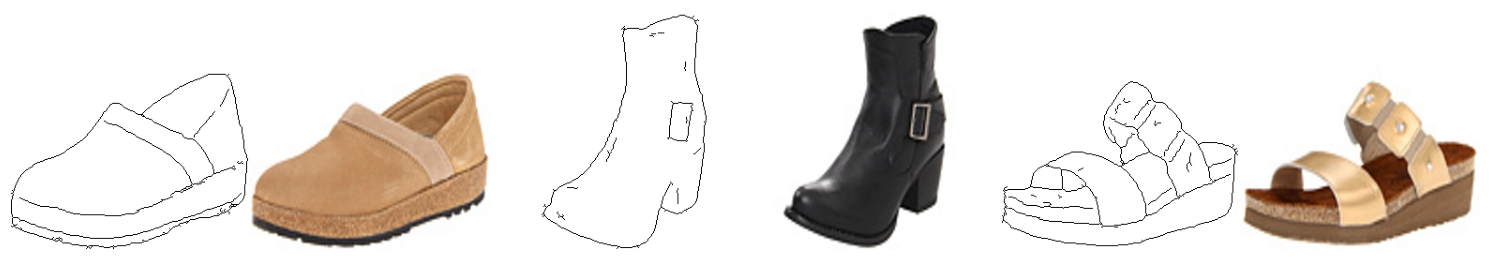

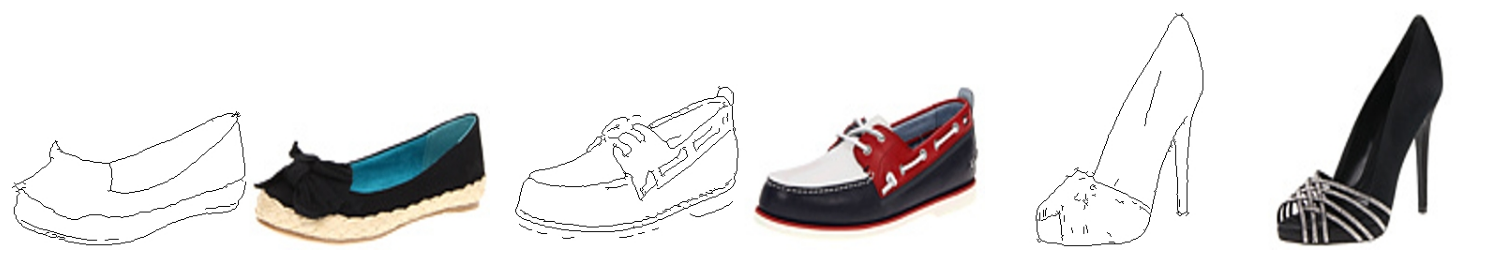

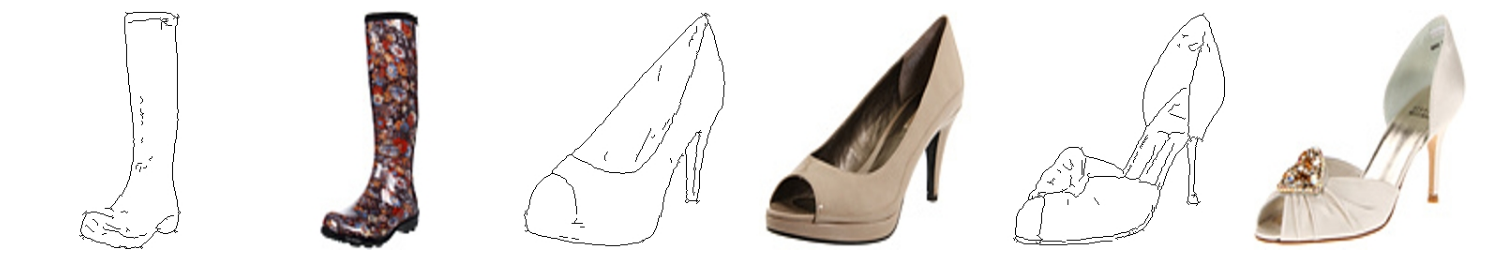

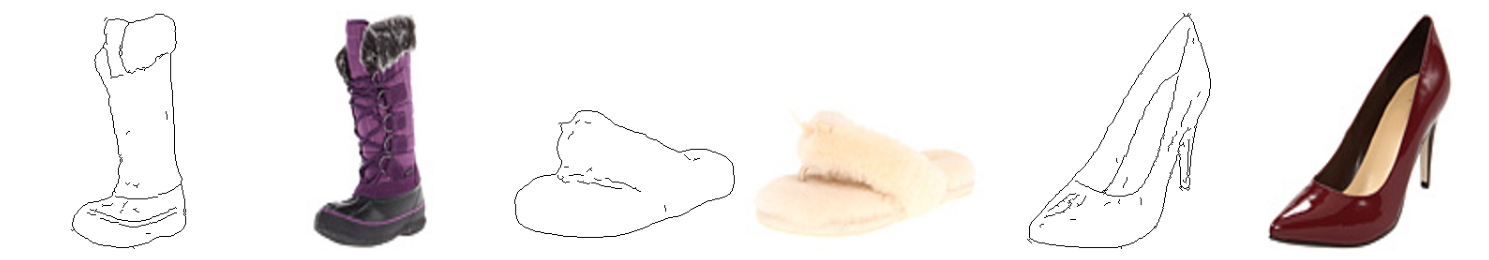

In [79]:
N_ROWS = 4
N_COLS = 3

for i in range(0, N_ROWS):
    fig, axs = plt.subplots(1, N_COLS, figsize=(15, 15))

    for j in range(N_COLS):
            id_j = np.random.randint(0, len(images_paths))
            img_path_i = images_paths[id_j]
            img_i = cv2.imread(img_path_i, 1)
            img_i = cv2.cvtColor(img_i, cv2.COLOR_BGR2RGB)

            axs[j].imshow(img_i, cmap='gray')
            axs[j].axis('off')

    fig.tight_layout()
    plt.show()

# Images Preprocessing

Blur Filters

In [80]:
# make image smooth
def apply_filter_gaussian(image, kernel_size=(5, 5), sigma=0):
    return cv2.GaussianBlur(image, kernel_size, sigma).astype(image.dtype)

# remove salt and pepper noise
def apply_filter_median(image, kernel_size=5):
    return cv2.medianBlur(image, kernel_size).astype(image.dtype)

# preserve edges while reducing noise
def apply_filter_bilateral(image, d=9, sigma_color=75, sigma_space=75):
    return cv2.bilateralFilter(image, d, sigma_color, sigma_space).astype(image.dtype)

Edge Detection

In [81]:
def apply_canny(image, threshold1=50, threshold2=110):
    return cv2.Canny(image, threshold1, threshold2).astype(image.dtype)

In [82]:
def preprocess_image_from_path(image_path, edge_type = 0):
    image = cv2.imread(image_path, 1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image = cv2.resize(image, (2 * IMG_W, IMG_H))

    edge_img = image[:,0:IMG_H]
    shoes_img = image[:,IMG_H:]

    shoes_img = apply_filter_median(shoes_img)
    
    edge_img = cv2.cvtColor(edge_img, cv2.COLOR_RGB2GRAY)
    edge_img = np.expand_dims(edge_img, axis=-1)

    shoes_img_grey_img = cv2.cvtColor(shoes_img, cv2.COLOR_RGB2GRAY)
    canny_edges = apply_canny(shoes_img_grey_img)

    shoes_img = (shoes_img / 255.0).astype(np.float32)
    
    edge_img = (edge_img / 255.0).astype(np.float32)
    canny_edges = (canny_edges / 255.0).astype(np.float32)
    
    canny_edges = 1 - canny_edges # swap black and white

    shoes_img = cv2.resize(shoes_img, (IMG_W, IMG_H))
    edge_img = cv2.resize(edge_img, (IMG_W, IMG_H))
    canny_edges = cv2.resize(canny_edges, (IMG_W, IMG_H))

    if len(edge_img.shape) == 2:
        edge_img = np.expand_dims(edge_img, axis = -1)
    
    if len(canny_edges.shape) == 2:
        canny_edges = np.expand_dims(canny_edges, axis = -1)

    shoes_img = shoes_img * 2 - 1
    edge_img = edge_img * 2 - 1
    canny_edges = canny_edges * 2 - 1
    
    return [shoes_img, edge_img, canny_edges]

(256, 256, 3) (256, 256, 1) (256, 256, 1) 1.0 -0.96862745 1.0 -1.0 1.0 -1.0


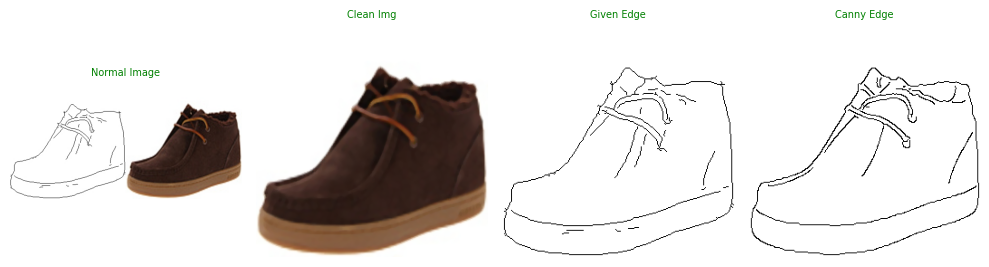

(256, 256, 3) (256, 256, 1) (256, 256, 1) 1.0 -0.90588236 1.0 -1.0 1.0 -1.0


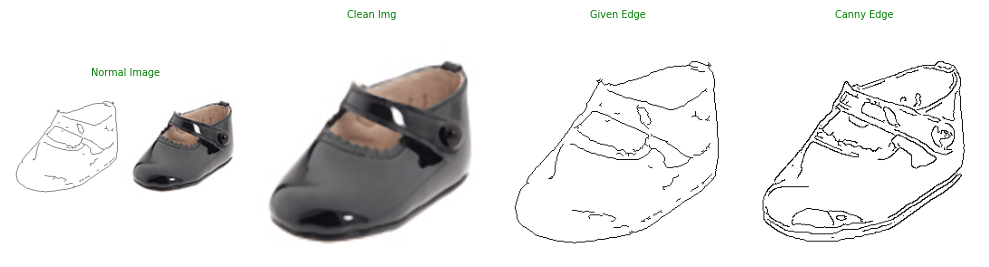

(256, 256, 3) (256, 256, 1) (256, 256, 1) 1.0 -0.8980392 1.0 -1.0 1.0 -1.0


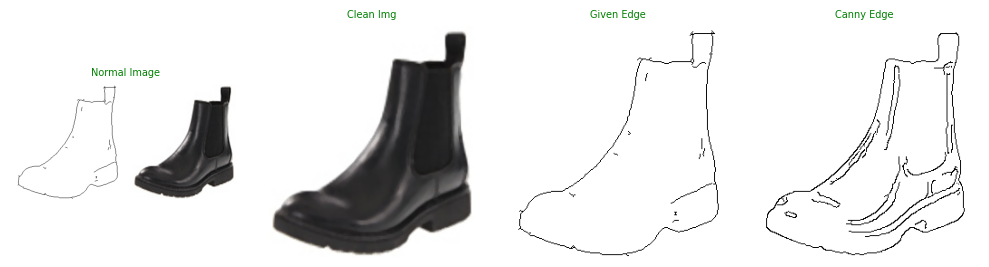

(256, 256, 3) (256, 256, 1) (256, 256, 1) 1.0 -0.9137255 1.0 -1.0 1.0 -1.0


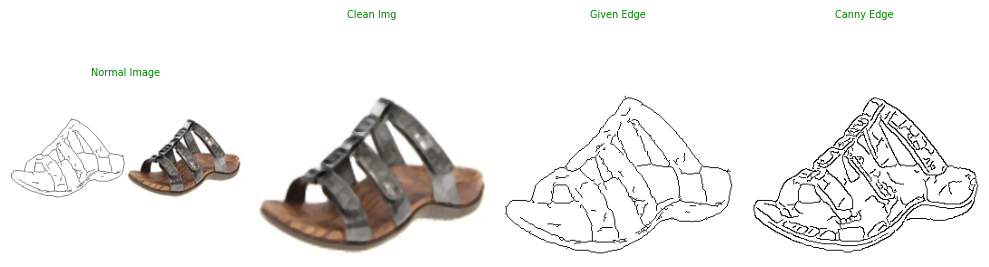

(256, 256, 3) (256, 256, 1) (256, 256, 1) 1.0 -0.92941177 1.0 -1.0 1.0 -1.0


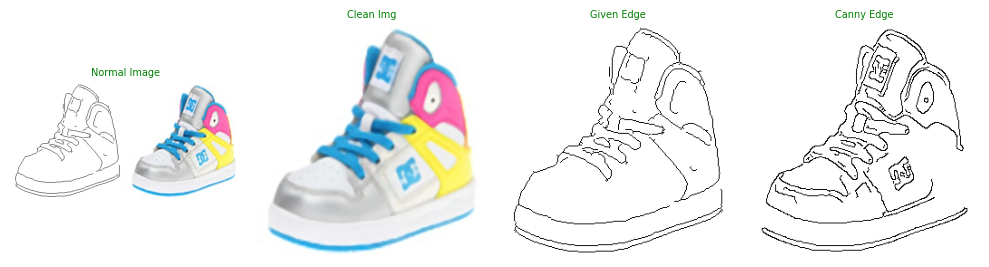

In [83]:
N_ROWS = 5
IMG_SHAPE = None

for i in range(0, N_ROWS):
    fig, axs = plt.subplots(1, 4, figsize=(10, 4))
    id_j = np.random.randint(0, len(images_paths))
    img_path_i = images_paths[id_j]

    img_i = cv2.imread(img_path_i, 1)
    img_i = cv2.cvtColor(img_i, cv2.COLOR_BGR2RGB)
    img_i_processed, edge_img, canny_img = preprocess_image_from_path(img_path_i)

    print(img_i_processed.shape, edge_img.shape,  canny_img.shape ,np.max(img_i_processed), np.min(img_i_processed), np.max(edge_img), np.min(edge_img), np.max(canny_img), np.min(canny_img))

    axs[0].imshow(img_i.squeeze())
    axs[0].set_title(f"Normal Image", fontsize=7, color='green')
    axs[0].axis('off')

    axs[1].imshow(img_i_processed * 0.5 + 0.5)
    axs[1].set_title(f"Clean Img", fontsize=7, color='green')
    axs[1].axis('off')

    axs[2].imshow(edge_img * 0.5 + 0.5, cmap='gray')
    axs[2].set_title(f"Given Edge", fontsize=7, color='green')
    axs[2].axis('off')

    axs[3].imshow(canny_img * 0.5 + 0.5, cmap='gray')
    axs[3].set_title(f"Canny Edge", fontsize=7, color='green')
    axs[3].axis('off')
    
    IMG_SHAPE = img_i_processed.shape

    fig.tight_layout()
    plt.show()

# Data Split

In [84]:
threshold = VAL_SPLIT * len(images_paths)

np.random.shuffle(images_paths)
images_paths_train = images_paths[:-int(threshold)]
images_paths_val = images_paths[-int(threshold):]

In [85]:
print(f"Train images: {len(images_paths_train)}")
print(f"Val images: {len(images_paths_val)}")

Train images: 10500
Val images: 4500


# Data Augmentation

In [86]:
def custom_augmentation_numpy(image, edge_img):
    # -----------------------------
    # 1. Random Horizontal Flip
    if np.random.rand() > 0.5:
        image = np.fliplr(image)
        edge_img = np.fliplr(edge_img)

    # -----------------------------
    # 2. Random Vertical Flip
    # if np.random.rand() > 0.5:
    #     image = np.flipud(image)
    #     edge_img = np.flipud(edge_img)

    # -----------------------------
    # 3. Random Rotation (-15 to 15 degrees)
    if np.random.rand() > 0.5:
        angle = np.random.uniform(-15, 15)
        h, w = image.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        image = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REFLECT_101)
        edge_img = cv2.warpAffine(edge_img, M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REFLECT_101)

    # -----------------------------
    # 4. Random Crop and Resize Back
    if np.random.rand() > 0.5:
        h, w = image.shape[:2]
        crop_scale = np.random.uniform(0.9, 1.0)
        new_h, new_w = int(h * crop_scale), int(w * crop_scale)
        top = np.random.randint(0, h - new_h + 1)
        left = np.random.randint(0, w - new_w + 1)
        image = image[top:top + new_h, left:left + new_w]
        edge_img = edge_img[top:top + new_h, left:left + new_w]
        image = cv2.resize(image, (w, h))
        edge_img = cv2.resize(edge_img, (w, h), interpolation=cv2.INTER_NEAREST)

    # -----------------------------
    # 5. Random Brightness (image only)
    if np.random.rand() > 0.5:
        brightness_shift = np.random.uniform(-0.05, 0.05)
        image = image + brightness_shift
        image = np.clip(image, -1, 1)

    # -----------------------------
    # 6. Random Contrast (image only)
    if np.random.rand() > 0.5:
        factor = np.random.uniform(0.8, 1.2)
        mean = image.mean(axis=(0, 1), keepdims=True)
        image = (image - mean) * factor + mean
        image = np.clip(image, -1, 1)

    # -----------------------------
    # 7. Random Gaussian Noise (image only)
    if np.random.rand() > 0.5:
        noise = np.random.normal(0, 0.025, image.shape)
        image = image + noise
        image = np.clip(image, -1, 1)

    # Ensure edge_img has channel dimension
    if len(edge_img.shape) == 2:
        edge_img = np.expand_dims(edge_img, axis=-1)

    # -----------------------------
    # No need to rescale anymore

    return image, edge_img


In [87]:
class MyDataGenerator(Sequence):
    # Shared cache across all objects of this class
    _shared_image_cache = dict()

    def __init__(self, images_paths, batch_size=32, augment=True, shuffle=True, n_workers=4):
        self.images_paths = np.array(images_paths)
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.n_workers = n_workers
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.images_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images_paths = self.images_paths[batch_x]

        batch_images_edge_pairs = self._load_images_parallel(batch_images_paths)

        if self.augment:
            batch_images_edge_pairs = [custom_augmentation_numpy(*img) for img in batch_images_edge_pairs]

        return np.array([x[1] for x in batch_images_edge_pairs]), np.array([x[0] for x in batch_images_edge_pairs])

    def on_epoch_end(self):
        self.indices = np.arange(len(self.images_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def _load_images_parallel(self, paths):
        with ThreadPoolExecutor(max_workers=self.n_workers) as executor:
            image_edge_pairs = list(executor.map(self._load_and_preprocess_single, paths))
        return image_edge_pairs

    def _load_and_preprocess_single(self, path):
        if path in MyDataGenerator._shared_image_cache:
            selected_pair =  MyDataGenerator._shared_image_cache[path]
        else:
            image_edge_pair = preprocess_image_from_path(path)
            MyDataGenerator._shared_image_cache[path] = image_edge_pair
            selected_pair =  image_edge_pair

        img, given_edge, canny_edge = selected_pair

        return img, [given_edge, canny_edge][int(np.random.rand() > 0.5)]

    @classmethod
    def clear_cache(cls):
        cls._shared_image_cache.clear()

In [88]:
train_generator = MyDataGenerator(images_paths_train, batch_size=BATCH_SIZE, augment=True, shuffle=True)

train_pure_generator = MyDataGenerator(images_paths_train, batch_size=BATCH_SIZE, augment=False, shuffle=False)
val_generator = MyDataGenerator(images_paths_val, batch_size=BATCH_SIZE, augment=False, shuffle=False)

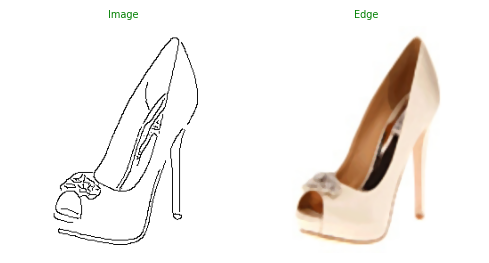

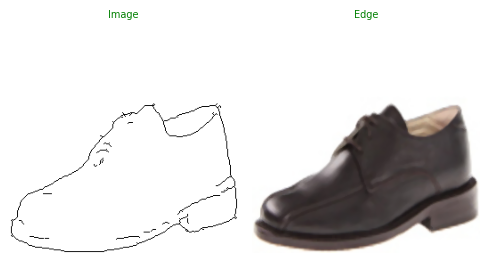

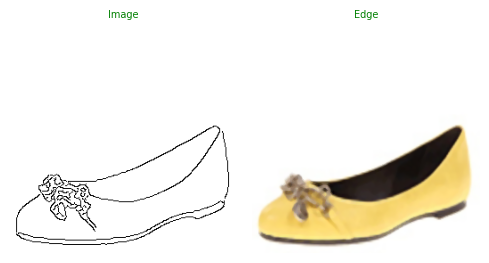

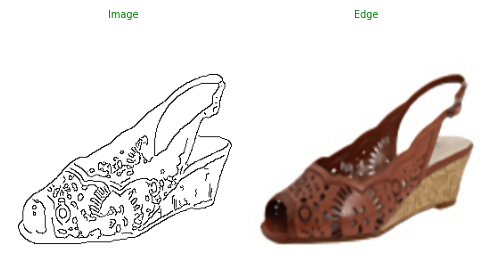

In [89]:
random_batch_x,random_batch_y  = val_generator[0]

for i in range(4):
    fig, axs = plt.subplots(1, 2, figsize=(5,5))
    axs[0].imshow(random_batch_x[i] * 0.5 + 0.5, cmap='gray')
    axs[0].set_title(f"Image", fontsize=7, color='green')
    axs[0].axis('off')
    axs[1].imshow(random_batch_y[i]  * 0.5 + 0.5, cmap='gray')
    axs[1].set_title(f"Edge", fontsize=7, color='green')
    axs[1].axis('off')

    fig.tight_layout()
    plt.show()

# Model Encapsulation

In [148]:
CACHE_MODELS_DIR_NAME = os.path.join(BASE_DIR)
os.makedirs(CACHE_MODELS_DIR_NAME, exist_ok=True)

In [149]:
class CustomModel:
    def __init__(self, name, gen_model, discrim_model):
        self.name = re.sub('[^A-Za-z0-9]', '_', str(name)).lower()
        self.gen_model = gen_model
        self.discrim_model = discrim_model
        self.trained = False

        # Optimizers
        self.gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
        self.disc_optimizer = tf.keras.optimizers.Adam(0.00001, beta_1=0.5)


        # Track losses
        self.loss_history = {
            "discriminator": [],
            "generator": []
        }

        self.load()

    def l1_loss(self, y_true, y_pred):
        return tf.reduce_mean(tf.abs(y_true - y_pred))

    def ssim_loss(self, y_true, y_pred):
        # SSIM works on [0, max_val]. Your range is [-1, 1], so max_val = 2.
        return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=2.0))
    
    def generator_loss(self, fake_output, y_true, y_pred, l1_weight=100, ssim_weight=50, background_weight=50):
        # GAN loss (LSGAN)
        gan_loss = tf.reduce_mean(tf.square(fake_output - 1))
    
        # L1 loss
        l1 = self.l1_loss(y_true, y_pred)
    
        # SSIM loss
        ssim = self.ssim_loss(y_true, y_pred)
    
        # --- Background loss for white areas (+1 in [-1, 1]) ---
        background_mask = tf.greater_equal(y_true, 0.95)  # threshold near +1 (white)
        
        # Force predicted background to +1 (white in [-1, 1])
        background_area = tf.boolean_mask(y_pred, background_mask)
        background_loss = tf.reduce_mean(tf.abs(background_area - 1.0))
    
        # --- Total combined loss ---
        total = (
            gan_loss +
            l1_weight * l1 +
            ssim_weight * ssim +
            background_weight * background_loss
        )
        return total



    def discriminator_loss(self, real_output, fake_output):
        # Label smoothing for real labels: 0.8 to 1.0 instead of 1
        real_labels = tf.random.uniform(shape=tf.shape(real_output), minval=0.8, maxval=1.0)
        fake_labels = tf.random.uniform(shape=tf.shape(fake_output), minval=0.0, maxval=0.2)
    
        real_loss = tf.reduce_mean(tf.square(real_output - real_labels))
        fake_loss = tf.reduce_mean(tf.square(fake_output - fake_labels))
    
        return 0.5 * (real_loss + fake_loss)


    def add_noise(self, x, std=0.1):
        return x + tf.random.normal(shape=tf.shape(x), stddev=std)

    @tf.function
    def train_step(self, x, y):
        x = tf.cast(x, tf.float32)
        y = tf.cast(y, tf.float32)
    
        with tf.GradientTape(persistent=True) as tape:
            # Generator output
            fake_y = self.gen_model(x, training=True)
    
            # Discriminator outputs
            real_output = self.discrim_model(self.add_noise(y), training=True)
            fake_output = self.discrim_model(self.add_noise(fake_y), training=True)
    
            # Losses
            disc_loss = self.discriminator_loss(real_output, fake_output)
            gen_loss = self.generator_loss(fake_output, y, fake_y)
    
        # Gradients
        disc_grads = tape.gradient(disc_loss, self.discrim_model.trainable_variables)
        gen_grads = tape.gradient(gen_loss, self.gen_model.trainable_variables)
    
        # Optimizer steps
        self.disc_optimizer.apply_gradients(zip(disc_grads, self.discrim_model.trainable_variables))
        if disc_loss > 0.3:
            self.disc_optimizer.apply_gradients(zip(disc_grads, self.discrim_model.trainable_variables))
        else:
            stddev = 0.05 / (disc_loss + 0.05)
            stddev = tf.minimum(stddev, 0.2)
            for var in self.discrim_model.trainable_variables:
                noise = tf.random.normal(shape=tf.shape(var), stddev = stddev)
                var.assign_add(noise)
                
        return disc_loss, gen_loss

        
    def fit(self, data_gen, epochs, val_data=None):
        for epoch in range(epochs):
            print(f'\nEpoch {epoch + 1}/{epochs}')
            total_d_loss = 0
            total_g_loss = 0
            batches = len(data_gen)
    
            for batch_i in range(batches):
                x_train, y_train = data_gen[batch_i]
    
                d_loss, g_loss = self.train_step(x_train, y_train)
                total_d_loss += d_loss.numpy()
                total_g_loss += g_loss.numpy()
    
                if batch_i % 10 == 0:
                    print(f'Batch {batch_i + 1}/{batches} | D Loss: {d_loss.numpy():.4f} | G Loss: {g_loss.numpy():.4f}')
    
            avg_d_loss = total_d_loss / batches
            avg_g_loss = total_g_loss / batches
    
            self.loss_history["discriminator"].append(avg_d_loss)
            self.loss_history["generator"].append(avg_g_loss)
    
            self.save()
    
            # -------------------------
            # Plot every (1) epochs
            if (epoch + 1) % (1) == 0 and val_data is not None:
                x_val, y_val = val_data[0]
                self.plot_sample_results(x_val[:3], y_val[:3], epoch=len(self.loss_history["discriminator"]))
            # -------------------------
    
        self.trained = True


    def load(self):
        g_file_path = f'{CACHE_MODELS_DIR_NAME}/{self.name}_generator.weights.h5'
        d_file_path = f'{CACHE_MODELS_DIR_NAME}/{self.name}_discrim.weights.h5'
        loss_file_path = f'{CACHE_MODELS_DIR_NAME}/{self.name}_loss.json'

        try:
            self.gen_model.load_weights(g_file_path)
            self.trained = True
            print(f'Loaded weights for {self.name} G')
        except Exception as e:
            print(f'No saved weights found for {self.name} G, starting fresh.')
        
        try:
            self.discrim_model.load_weights(d_file_path)
            self.trained = True
            print(f'Loaded weights for {self.name} D')
        except Exception as e:
            print(f'No saved weights found for {self.name} D, starting fresh.')

        if os.path.exists(loss_file_path):
            with open(loss_file_path, 'r') as f:
                self.loss_history = json.load(f)
            print(f'Loaded loss history for {self.name}')
        else:
            print('No previous loss history found, starting fresh.')

    def save(self):
        # Save weights
        self.gen_model.save_weights(f'{CACHE_MODELS_DIR_NAME}/{self.name}_generator.weights.h5')
        self.discrim_model.save_weights(f'{CACHE_MODELS_DIR_NAME}/{self.name}_discrim.weights.h5')

        # Save loss history
        loss_file_path = f'{CACHE_MODELS_DIR_NAME}/{self.name}_loss.json'
        with open(loss_file_path, 'w') as f:
            json.dump(self.loss_history, f)

        print(f'Saved model and losses for {self.name}')

    def plot_sample_results(self, x_samples, y_samples, epoch):
        preds = self.gen_model.predict(x_samples)
    
        fig, axes = plt.subplots(3, 3, figsize=(9, 9))
        fig.suptitle(f'{self.name} - Epoch {epoch} Sample Predictions', fontsize=16)
    
        for i in range(3):
            edge_img = x_samples[i].squeeze()
            gt_img = y_samples[i]
            pred_img = preds[i]
    
            if edge_img.ndim == 2:
                edge_img = np.stack([edge_img]*3, axis=-1)
    
            axes[i, 0].imshow(edge_img * 0.5 + 0.5)
            axes[i, 0].set_title('Edge Input')
            axes[i, 1].imshow(gt_img * 0.5 + 0.5)
            axes[i, 1].set_title('Ground Truth')
            axes[i, 2].imshow((pred_img + 1) / 2)  # assuming tanh [-1, 1]
            axes[i, 2].set_title('Prediction')
    
            for j in range(3):
                axes[i, j].axis('off')
    
        plt.tight_layout()
    
        save_dir = os.path.join(CACHE_MODELS_DIR_NAME, f"{self.name}_plots")
        os.makedirs(save_dir, exist_ok=True)
    
        plt.savefig(os.path.join(save_dir, f"epoch_{epoch}.png"))
        plt.close(fig)


# Models Arch

In [150]:
models_list = list()

In [151]:
def SE_Block(input_tensor, reduction=16):
    filters = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(filters // reduction, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = Reshape((1, 1, filters))(se)
    return Multiply()([input_tensor, se])


def ResidualBlock(x, filters):
    shortcut = x
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([shortcut, x])
    x = LeakyReLU(0.2)(x)
    return x


def build_gan_model_1():
    global models_list
    NAME = 'gan_deep_v1'

    inputs = Input((IMG_W, IMG_H, 1))

    # Encoder
    e1 = Conv2D(64, 4, strides=2, padding='same')(inputs)
    e1 = LeakyReLU(0.2)(e1)

    e2 = Conv2D(128, 4, strides=2, padding='same')(e1)
    e2 = BatchNormalization()(e2)
    e2 = LeakyReLU(0.2)(e2)

    e3 = Conv2D(256, 4, strides=2, padding='same')(e2)
    e3 = BatchNormalization()(e3)
    e3 = LeakyReLU(0.2)(e3)

    e4 = Conv2D(512, 4, strides=2, padding='same')(e3)
    e4 = BatchNormalization()(e4)
    e4 = LeakyReLU(0.2)(e4)

    # Bottleneck + Residuals + SE block
    b = Conv2D(1024, 4, strides=2, padding='same')(e4)
    b = BatchNormalization()(b)
    b = Activation('relu')(b)
    for _ in range(3):
        b = ResidualBlock(b, 1024)
    b = SE_Block(b)

    # Decoder
    d1 = Conv2DTranspose(512, 4, strides=2, padding='same')(b)
    d1 = BatchNormalization()(d1)
    d1 = Dropout(0.5)(d1)
    d1 = Activation('relu')(d1)
    d1 = Concatenate()([d1, e4])

    d2 = Conv2DTranspose(256, 4, strides=2, padding='same')(d1)
    d2 = BatchNormalization()(d2)
    d2 = Dropout(0.5)(d2)
    d2 = Activation('relu')(d2)
    d2 = Concatenate()([d2, e3])

    d3 = Conv2DTranspose(128, 4, strides=2, padding='same')(d2)
    d3 = BatchNormalization()(d3)
    d3 = Activation('relu')(d3)
    d3 = Concatenate()([d3, e2])

    d4 = Conv2DTranspose(64, 4, strides=2, padding='same')(d3)
    d4 = BatchNormalization()(d4)
    d4 = Activation('relu')(d4)
    d4 = Concatenate()([d4, e1])

    d5 = Conv2DTranspose(64, 4, strides=2, padding='same')(d4)
    d5 = BatchNormalization()(d5)
    d5 = Activation('relu')(d5)

    outputs = Conv2D(3, 1, activation='tanh')(d5)

    gen_model = Model(inputs, outputs)
    gen_model.summary()

    ### --- Discriminator ---
    disc_in = Input((IMG_H, IMG_W, 3))

    d = Conv2D(16, 4, strides=2, padding='same')(disc_in)
    d = ReLU()(d)
    d = Dropout(0.3)(d)
    
    d = Conv2D(32, 4, strides=2, padding='same')(d)
    d = BatchNormalization()(d)
    d = ReLU()(d)
    d = Dropout(0.3)(d)
    
    d = Conv2D(64, 4, strides=2, padding='same')(d)
    d = BatchNormalization()(d)
    d = ReLU()(d)
    d = Dropout(0.3)(d)
    
    d = Conv2D(256, 4, strides=1, padding='same')(d)
    d = BatchNormalization()(d)
    d = ReLU()(d)
    d = Dropout(0.3)(d)

    outputs = Conv2D(1, 4, strides=1, padding='same')(d)

    descrim_model = Model(disc_in, outputs)
    descrim_model.summary()

    # Entire model
    entire_input = Input(shape=(IMG_H, IMG_W, 1))
    gen_output = gen_model(entire_input)
    discrim_output = descrim_model(gen_output)

    entire_model = Model(entire_input, discrim_output)

    custom_model = CustomModel(NAME, gen_model, descrim_model)
    models_list = list(filter(lambda x: x.name != custom_model.name, models_list))
    models_list.append(custom_model)
    
build_gan_model_1()

Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_32      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_188 (Conv2D) │ (None, 128, 128,  │      1,088 │ input_layer_32[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_140     │ (None, 128, 128,  │          0 │ conv2d_188[0][0]  │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_189 (Conv2D) │ (None, 64, 64,    │    131,200 │ leaky_re_lu_140[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_189[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_141     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_190 (Conv2D) │ (None, 32, 32,    │    524,544 │ leaky_re_lu_141[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_190[0][0]  │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_142     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_191 (Conv2D) │ (None, 16, 16,    │  2,097,664 │ leaky_re_lu_142[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      2,048 │ conv2d_191[0][0]  │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_143     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_192 (Conv2D) │ (None, 8, 8,      │  8,389,632 │ leaky_re_lu_143[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8,      │      4,096 │ conv2d_192[0][0]  │
│ (BatchNormalizatio… │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_72       │ (None, 8, 8,      │          0 │ batch_normalizat… │
│ (Activation)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_193 (Conv2D) │ (None, 8, 8,      │  9,438,208 │ activation_72[0]… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8,      │      4,096 │ conv2d_193[0][0]

 Total params: 81,967,811 (312.68 MB)

 Trainable params: 81,949,635 (312.61 MB)

 Non-trainable params: 18,176 (71.00 KB)

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_33 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_200 (Conv2D)             │ (None, 128, 128, 16)   │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_12 (ReLU)                 │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_201 (Conv2D)             │ (None, 64, 64, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_220         │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_13 (ReLU)                 │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_202 (Conv2D)             │ (None, 32, 32, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_221         │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_14 (ReLU)                 │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_203 (Conv2D)             │ (None, 32, 32, 256)    │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_222         │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_15 (ReLU)                 │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_204 (Conv2D)             │ (None, 32, 32, 1)      │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 309,745 (1.18 MB)

 Trainable params: 309,041 (1.18 MB)

 Non-trainable params: 704 (2.75 KB)

Loaded weights for gan_deep_v1 G
Loaded weights for gan_deep_v1 D
Loaded loss history for gan_deep_v1


In [152]:
for model in models_list:

        plot_model(
            model.gen_model,
            to_file=  os.path.join(CACHE_MODELS_DIR_NAME,f'{model.name}_gen_arch.png'),
            show_shapes=True,
            dpi =200,
            show_layer_names=True,
            expand_nested=True,
            show_layer_activations=True,
            show_trainable=True,
            show_dtype=True,
        )

        plot_model(
            model.discrim_model,
            to_file=  os.path.join(CACHE_MODELS_DIR_NAME,f'{model.name}_descrim_arch.png'),
            show_shapes=True,
            dpi =200,
            show_layer_names=True,
            expand_nested=True,
            show_layer_activations=True,
            show_trainable=True,
            show_dtype=True,
        )


# Model Training

In [ ]:
for i, model in enumerate(models_list):
    print(f"{i+1}. Train: {model.name}")
    model.fit(train_generator, epochs= 1, val_data = val_generator)
    print('\n')

1. Train: gan_deep_v1

Epoch 1/1


E0000 00:00:1753133151.807017   26629 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_29_1/dropout_54_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Batch 1/229 | D Loss: 34.8674 | G Loss: 61.8007
Batch 11/229 | D Loss: 33.5003 | G Loss: 61.9267
Batch 21/229 | D Loss: 31.9433 | G Loss: 67.4026
Batch 31/229 | D Loss: 31.6513 | G Loss: 61.9715
Batch 41/229 | D Loss: 30.4233 | G Loss: 63.8907
Batch 51/229 | D Loss: 30.0046 | G Loss: 59.2284
Batch 61/229 | D Loss: 29.2244 | G Loss: 61.3478
Batch 71/229 | D Loss: 28.6620 | G Loss: 61.1727
Batch 81/229 | D Loss: 27.9412 | G Loss: 58.2903
Batch 91/229 | D Loss: 27.4301 | G Loss: 62.6756


# Model Eval

In [ ]:
TEST_DIR_PATH = os.path.join(BASE_DIR,'test')
os.makedirs(TEST_DIR_PATH, exist_ok=True)

random_batch_x,random_batch_y  = val_generator[0]
random_batch_y_hat = models_list[0].gen_model.predict(random_batch_x)

for i in range(len(random_batch_x)):
    fig, axs = plt.subplots(1, 3, figsize=(5,5))
    axs[0].imshow(random_batch_x[i] * 0.5 + 0.5, cmap='gray')
    axs[0].set_title(f"Edge", fontsize=7, color='green')
    axs[0].axis('off')

    axs[1].imshow(random_batch_y[i] * 0.5 + 0.5)
    axs[1].set_title(f"True", fontsize=7, color='green')
    axs[1].axis('off')

    axs[2].imshow(random_batch_y_hat[i] * 0.5 + 0.5)
    axs[2].set_title(f"Predict Image", fontsize=7, color='green')
    axs[2].axis('off')

    fig.tight_layout()
    plt.savefig(os.path.join(TEST_DIR_PATH, f'test sample {i}.png'), dpi=300, bbox_inches='tight')  # dpi for quality, bbox_inches to avoid cutoff

In [ ]:
TRAIN_DIR_PATH = os.path.join(BASE_DIR,'train')
os.makedirs(TRAIN_DIR_PATH, exist_ok=True)

random_batch_x,random_batch_y = train_pure_generator[0]
random_batch_y_hat = models_list[0].gen_model.predict(random_batch_x)

for i in range(len(random_batch_x)):
    fig, axs = plt.subplots(1, 3, figsize=(5,5))
    axs[0].imshow(random_batch_x[i] * 0.5 + 0.5, cmap='gray')
    axs[0].set_title(f"Edge", fontsize=7, color='green')
    axs[0].axis('off')

    axs[1].imshow(random_batch_y[i] * 0.5 + 0.5, cmap='gray')
    axs[1].set_title(f"True", fontsize=7, color='green')
    axs[1].axis('off')

    axs[2].imshow(random_batch_y_hat[i] * 0.5 + 0.5, cmap='gray')
    axs[2].set_title(f"Predict Image", fontsize=7, color='green')
    axs[2].axis('off')

    fig.tight_layout()
    plt.savefig(os.path.join(TRAIN_DIR_PATH, f'train sample {i}.png'), dpi=300, bbox_inches='tight')  # dpi for quality, bbox_inches to avoid cutoff

# Depolyment